# Data Gen

The goal of this project is generate a synthetic dataset that mimics a real dataset.

Synthetic data is annotated information that computer simulations or algorithms generate as an alternative to real-world data. It may be artificial, but synthetic data reflects real-world data, mathematically or statistically. Research demonstrates it can be as good or even better for training an AI model than data based on actual objects, events or people.

Why is it so important? Developers need large, carefully labeled datasets to train neural networks. More diverse training data generally makes for more accurate AI models. The problem is gathering and labeling datasets that may contain a few thousand to tens of millions of elements is time consuming and often prohibitively expensive. Enter synthetic data. A single image that could cost $6 from a labeling service can be artificially generated for six cents, estimates Paul Walborsky, who co-founded one of the first dedicated synthetic data services, AI.Reverie.

In [1]:
import dataprofiler as dp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys 
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

from scipy import stats
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.svm import SVC

## Data Collection and Curation 

#### Loading Data 

In [2]:
data = pd.read_csv("loan_approval_data.csv")
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [3]:
# recognizing all the categorical variables 
cat_vars = ["Gender", "Married", "Education", "Self_Employed", "Property_Area", "Loan_Status", "Dependents", "Credit_History"] 

# checking number of unique values for each categorial variable 
for var in cat_vars: 
    print(data[var].unique())

['Male' 'Female' nan]
['No' 'Yes' nan]
['Graduate' 'Not Graduate']
['No' 'Yes' nan]
['Urban' 'Rural' 'Semiurban']
['Y' 'N']
['0' '1' '2' '3+' nan]
[ 1.  0. nan]


droppping loanID column

In [4]:
data = data.drop(['Loan_ID'], axis=1)
data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


## Exploratory Data Analysis

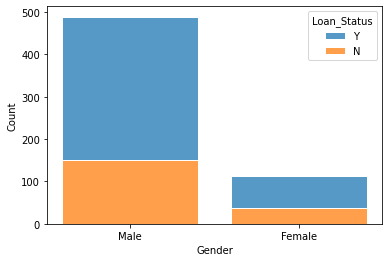

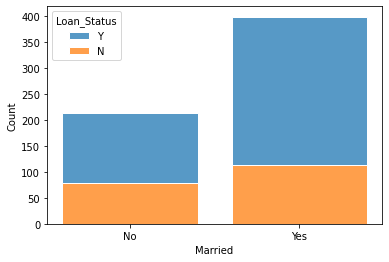

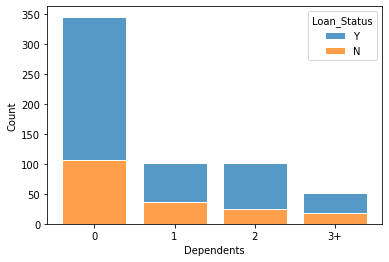

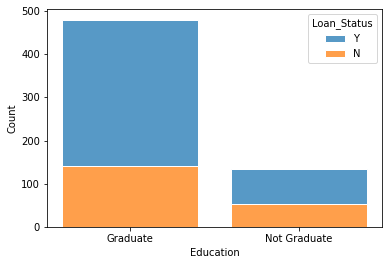

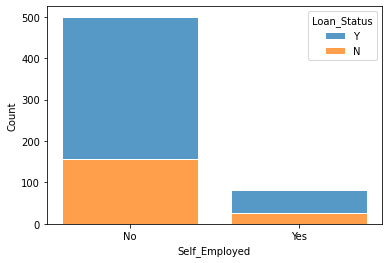

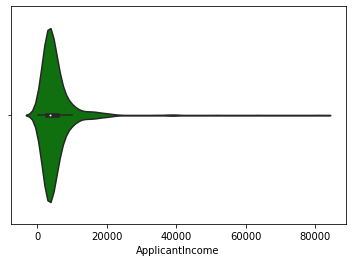

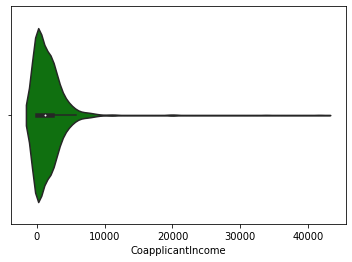

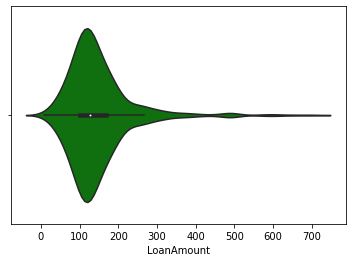

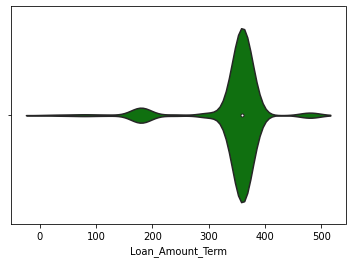

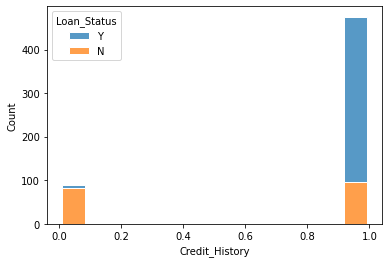

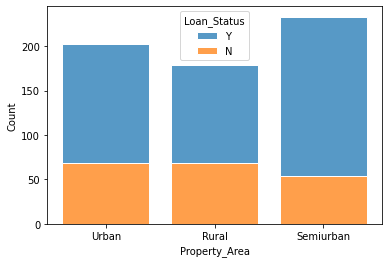

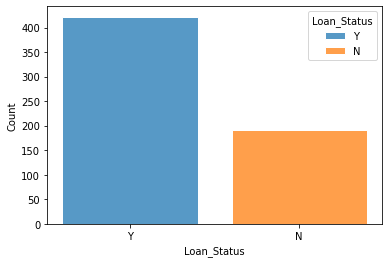

In [5]:
for col in data.columns:
    if len(data[col].value_counts()) < 10:
        #sns.histplot(data=data, x=col, hue = "Loan_Status")
        sns.histplot(
            data,
            x=col,
            # Use the value variable here to turn histogram counts into weighted
            # values.
            hue='Loan_Status',
            multiple='stack',
            # Add white borders to the bars.
            edgecolor='white',
            # Shrink the bars a bit so they don't touch.
            shrink=0.8
        )
    else:
        sns.violinplot(data=data, x=col, color = 'green')
    plt.show()

Some observations from the visual interpretation of the graphs
- More male applicants than female applicants
- More married applicants than unmarried, though the gap is not as wide as female vs male applicants
- More graduates than non-graduates
- Most applicants have 0 dependents
- More non-self employed applicants than self-employed applicants
- The most common loan amount term is 30 years by alot, the second most common being 15 years
- Pretty even distribution of property areas, with the most frequent being semiurban, then urban, and then rural
- Loan amount and applicant amounts are heavily right-skewed
- Alot of coapplicants have 0 income

Some charts like the loan amounts and applicant incomes are heavily right skewed, and contain outliers. Let's redo these charts after removing the outliers

In [6]:
data.loc[data["ApplicantIncome"] > 30000]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
155,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
171,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
183,Male,Yes,1,Graduate,No,33846,0.0,260.0,360.0,1.0,Semiurban,N
185,Male,Yes,0,Graduate,Yes,39147,4750.0,120.0,360.0,1.0,Semiurban,Y
333,Male,Yes,0,Graduate,NaN,63337,0.0,490.0,180.0,1.0,Urban,Y
409,Male,Yes,3+,Graduate,No,81000,0.0,360.0,360.0,0.0,Rural,N
443,Male,No,1,Graduate,No,37719,0.0,152.0,360.0,1.0,Semiurban,Y


<AxesSubplot:xlabel='ApplicantIncome'>

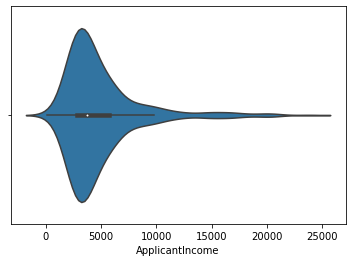

In [7]:
sns.violinplot(data=data[data["ApplicantIncome"] < 30000], x="ApplicantIncome")

In [8]:
data.loc[data["LoanAmount"] > 400]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
130,Male,No,0,Graduate,Yes,20166,0.0,650.0,480.0,NaN,Urban,Y
155,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
171,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
177,Male,Yes,3+,Graduate,No,5516,11300.0,495.0,360.0,0.0,Semiurban,N
278,Male,Yes,0,Graduate,No,14583,0.0,436.0,360.0,1.0,Semiurban,Y
308,Male,No,0,Graduate,No,20233,0.0,480.0,360.0,1.0,Rural,N
333,Male,Yes,0,Graduate,NaN,63337,0.0,490.0,180.0,1.0,Urban,Y
369,Male,Yes,0,Graduate,No,19730,5266.0,570.0,360.0,1.0,Rural,N
432,Male,No,0,Graduate,NaN,12876,0.0,405.0,360.0,1.0,Semiurban,Y
487,Male,Yes,1,Graduate,No,18333,0.0,500.0,360.0,1.0,Urban,N


<AxesSubplot:xlabel='LoanAmount'>

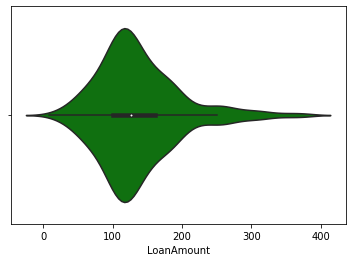

In [9]:
sns.violinplot(data=data[data["LoanAmount"] < 400], x="LoanAmount", color = 'green')

In [10]:
data.loc[data["CoapplicantIncome"] > 10000]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
9,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N
177,Male,Yes,3+,Graduate,No,5516,11300.0,495.0,360.0,0.0,Semiurban,N
402,Male,No,0,Graduate,No,2500,20000.0,103.0,360.0,1.0,Semiurban,Y
417,Male,Yes,2,Graduate,Yes,1600,20000.0,239.0,360.0,1.0,Urban,N
581,Male,No,0,Graduate,No,1836,33837.0,90.0,360.0,1.0,Urban,N
600,Female,No,3+,Graduate,NaN,416,41667.0,350.0,180.0,NaN,Urban,N


<AxesSubplot:xlabel='CoapplicantIncome'>

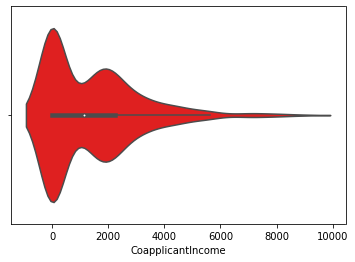

In [11]:
sns.violinplot(data=data[data["CoapplicantIncome"] < 10000], x="CoapplicantIncome", color='red')

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

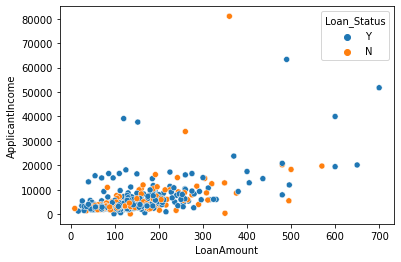

In [12]:
sns.scatterplot(y="ApplicantIncome", x="LoanAmount", data=data,  hue="Loan_Status") 

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

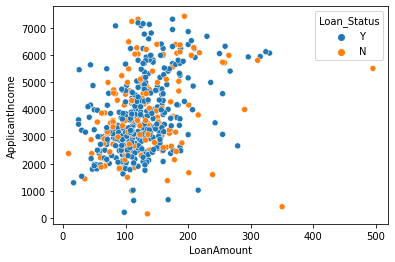

In [13]:
sns.scatterplot(y="ApplicantIncome", x="LoanAmount", data=data[data["ApplicantIncome"] < 7500], hue="Loan_Status") 

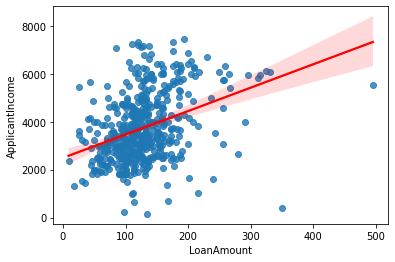

In [14]:
p = sns.regplot(y="ApplicantIncome", x="LoanAmount", data=data[data["ApplicantIncome"] < 7500], line_kws={"color": "red"})

x = p.get_lines()[0].get_xdata()
y = p.get_lines()[0].get_ydata()

In [15]:
# counting the NaNs in each column 
for col in data.columns: 
    print(col, data[col].isna().sum())

Gender 13
Married 3
Dependents 15
Education 0
Self_Employed 32
ApplicantIncome 0
CoapplicantIncome 0
LoanAmount 22
Loan_Amount_Term 14
Credit_History 50
Property_Area 0
Loan_Status 0


In [16]:
data['Gender'].fillna(data['Gender'].mode()[0],inplace=True)
data['Married'].fillna(data['Married'].mode()[0],inplace=True)
data['Dependents'].fillna(data['Dependents'].mode()[0],inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0],inplace=True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0],inplace=True)

We need to hot encode the categorical data variables so we can apply ML algorithms to this dataset

In [17]:
print(x[:5])
print(y[:5])

[ 9.         13.90909091 18.81818182 23.72727273 28.63636364]
[2577.43518239 2625.43161249 2673.42804258 2721.42447268 2769.42090277]


In [18]:
# slope of the regression line 
corr_val = (y[1] - y[0]) / (x[1] - x[0])
# y-intercept of the regression line
y_int = y[0] - (corr_val * x[0]) 
print(f"The correlation value is {corr_val} and the y-intercept is {y_int}")

The correlation value is 9.777050574767632 and the y-intercept is 2489.441727222022


In [19]:
for var in cat_vars: 
    print(data[var].unique().tolist())

['Male', 'Female']
['No', 'Yes']
['Graduate', 'Not Graduate']
['No', 'Yes']
['Urban', 'Rural', 'Semiurban']
['Y', 'N']
['0', '1', '2', '3+']
[1.0, 0.0]


In [20]:
hot_encode = {}

for cat_var in cat_vars:
    for i, var in enumerate(data[cat_var].unique().tolist()):
        hot_encode[var] = i
        
hot_encode[np.nan] = np.nan
hot_encode

{'Male': 0,
 'Female': 1,
 'No': 0,
 'Yes': 1,
 'Graduate': 0,
 'Not Graduate': 1,
 'Urban': 0,
 'Rural': 1,
 'Semiurban': 2,
 'Y': 0,
 'N': 1,
 '0': 0,
 '1': 1,
 '2': 2,
 '3+': 3,
 1.0: 0,
 0.0: 1,
 nan: nan}

In [21]:
for cat_var in cat_vars:
    new_col = []
    
    for _, row in data.iterrows():
        new_col.append(hot_encode[row[cat_var]])
    
    data[cat_var] = new_col

In [22]:
data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,0,0,0,0,5849,0.0,NaN,360.0,0,0,0
1,0,1,1,0,0,4583,1508.0,128.0,360.0,0,1,1
2,0,1,0,0,1,3000,0.0,66.0,360.0,0,0,0
3,0,1,0,1,0,2583,2358.0,120.0,360.0,0,0,0
4,0,0,0,0,0,6000,0.0,141.0,360.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,1,0,0,0,0,2900,0.0,71.0,360.0,0,1,0
610,0,1,3,0,0,4106,0.0,40.0,180.0,0,1,0
611,0,1,1,0,0,8072,240.0,253.0,360.0,0,0,0
612,0,1,2,0,0,7583,0.0,187.0,360.0,0,0,0


<AxesSubplot:>

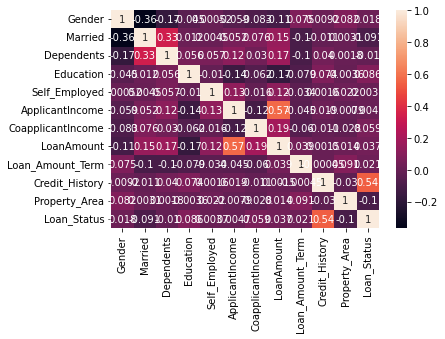

In [23]:
sns.heatmap(data.corr(), annot = True)

### Imputation

In [24]:
imputer = MissForest() 
X_imputed = imputer.fit_transform(data)

C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Iteration: 0


C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Iteration: 1


C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Iteration: 2


C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Iteration: 3


C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Iteration: 4


In [29]:
data_imputed = pd.DataFrame(X_imputed, columns=data.columns)

In [30]:
#lets round values in categorical columns (0/1 columns)
for cat_var in cat_vars:
    data_imputed = data_imputed.round({cat_var: 0})
    # data_imputed[cat_var] = data_imputed[cat_var].astype(int)

In [31]:
data_imputed

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0.0,0.0,0.0,0.0,0.0,5849.0,0.0,143.65,360.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,4583.0,1508.0,128.00,360.0,0.0,1.0,1.0
2,0.0,1.0,0.0,0.0,1.0,3000.0,0.0,66.00,360.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,2583.0,2358.0,120.00,360.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,6000.0,0.0,141.00,360.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,1.0,0.0,0.0,0.0,0.0,2900.0,0.0,71.00,360.0,0.0,1.0,0.0
610,0.0,1.0,3.0,0.0,0.0,4106.0,0.0,40.00,180.0,0.0,1.0,0.0
611,0.0,1.0,1.0,0.0,0.0,8072.0,240.0,253.00,360.0,0.0,0.0,0.0
612,0.0,1.0,2.0,0.0,0.0,7583.0,0.0,187.00,360.0,0.0,0.0,0.0


In [28]:
profile_options = dp.ProfilerOptions()
profile_options.set({"correlation.is_enabled": True})

profile = dp.Profiler(data, options=profile_options)

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 12 processes)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.10it/s]


INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.03it/s]


In [ ]:
report = profile.report()

In [ ]:
n_samples = report["global_stats"]["samples_used"]
n_variables = len(report["data_stats"])
seed = 123

In [ ]:
# build cov matrix
R = report["global_stats"]["correlation_matrix"].round(decimals=8)

stddevs = [stat["statistics"]["stddev"] for stat in report["data_stats"]]
D = np.diag(stddevs)

cov = D @ R @ D
cov = cov.round(decimals=8)

In [ ]:
# initialize X array

means = np.zeros(n_variables)
mvnorm = stats.multivariate_normal(mean=means, cov=cov)
x = mvnorm.rvs(n_samples)
x[0]

array([-3.53721663e-01, -6.74416902e-01,  9.13356683e-01, -6.02008562e-01,
       -3.17236493e-02,  5.38399614e+03, -3.52306076e+02, -1.31631563e+02,
        2.70403181e+01, -3.86784157e-02, -3.50506433e-01,  2.70627846e-01])

In [ ]:
# now tranform marginals back to uniform distribution

norm = stats.norm()
x = norm.cdf(x)
x[0]

array([0.36177374, 0.25002315, 0.81947251, 0.27358422, 0.48734622,
       1.        , 0.        , 0.        , 1.        , 0.48457339,
       0.36297933, 0.60666136])

In [ ]:
# generate scalers by range of values in original data

scalers = {}
for col, stat in enumerate(report["data_stats"]):
    _min = stat["statistics"]["min"]
    _max = stat["statistics"]["max"]
    scalers[col] = MinMaxScaler(feature_range=(_min, _max))

In [ ]:
# rescale to feature range

for col in scalers:
    x[:, col] = (
        scalers[col]
        .fit_transform(x[:, col].reshape(-1, 1))
        .flatten()
    )

In [ ]:
# find number of decimals for each column and round the data to match
precisions = [stat["samples"][0][::-1].find(".") for stat in report["data_stats"]]

for i, precision in enumerate(precisions):
    x[:, i] = np.around(x[:, i], precision if precision > 0 else 0)

In [21]:
new_data = pd.DataFrame(x, columns=[stat["column_name"] for stat in report["data_stats"]])

In [22]:
new_data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0.0,1.0,2.0,0.0,1.0,81000.0,33837.0,600.0,36.0,0.7,2.0,1.0
1,1.0,0.0,1.0,1.0,1.0,81000.0,0.0,600.0,36.0,0.3,1.0,0.0
2,1.0,0.0,2.0,1.0,1.0,150.0,33837.0,9.0,36.0,0.8,1.0,1.0
3,1.0,0.0,1.0,0.0,0.0,150.0,33837.0,9.0,36.0,0.6,1.0,1.0
4,1.0,0.0,2.0,0.0,0.0,150.0,33837.0,9.0,36.0,0.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.0,0.0,2.0,1.0,1.0,150.0,33837.0,9.0,480.0,0.8,1.0,1.0
476,1.0,0.0,1.0,1.0,1.0,150.0,33837.0,9.0,480.0,0.6,2.0,1.0
477,0.0,0.0,0.0,1.0,1.0,150.0,33837.0,9.0,480.0,0.4,1.0,0.0
478,0.0,1.0,3.0,1.0,1.0,81000.0,0.0,9.0,480.0,0.3,2.0,1.0


<AxesSubplot:>

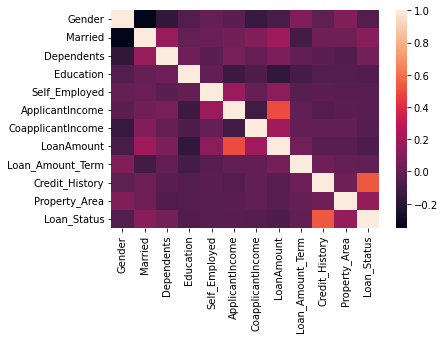

In [23]:
sns.heatmap(data.corr())

<AxesSubplot:>

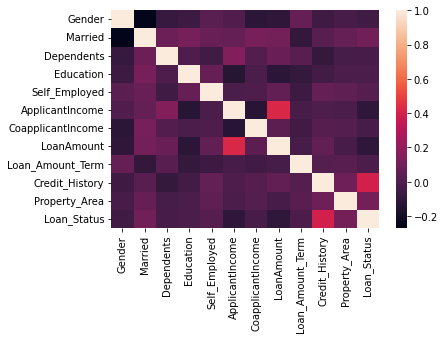

In [24]:
sns.heatmap(new_data.corr())

In [25]:
X = data.drop(["Loan_Status"], axis=1)
y = data["Loan_Status"]

training_data, test_data = train_test_split(X, test_size=0.2, random_state=seed)
training_target, test_target = train_test_split(y, test_size=0.2, random_state=seed)

clf = SVC()

clf.fit(training_data, training_target)

SVC()

In [130]:
test_results = clf.predict(test_data)
print(test_results) 

model_accuracy = list(test_results == test_target).count(True) / len(test_target)
print(test_target)
print(f"The model was {round(model_accuracy * 100, 2)}% accurate on the authentic data")

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
540    1
360    0
6      1
386    1
511    1
      ..
534    1
548    0
1      0
493    1
559    1
Name: Loan_Status, Length: 96, dtype: int64
The model was 62.5% accurate on the authentic data


In [129]:
synthetic_data = new_data.to_numpy()[:,:-1]
synthetic_target = new_data.to_numpy()[:,-1:].flatten()

synthetic_results = clf.predict(synthetic_data)
synthetic_accuracy = list(synthetic_results == synthetic_target).count(True) / len(synthetic_target)

print(f"The model was {round(synthetic_accuracy * 100, 2)}% accurate on the synthetic data")

The model was 46.04% accurate on the synthetic data


C:\Users\omhpa\miniconda3\envs\env1\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
